In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
amananandrai_ag_news_classification_dataset_path = kagglehub.dataset_download('amananandrai/ag-news-classification-dataset')

print('Data source import complete.')


Data source import complete.


# <p style="font-family:Arial;font-size:150%;text-align:center;color:#FF0000;"> AG News Classification</p>

# <p style="font-family:Arial;font-size:150%;text-align:center;color:#FF0000;"> Thư viện</p>

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
import re
import string

from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# <p style="font-family:Arial;font-size:150%;text-align:center;color:#FF0000;"> Tải dữ liệu</p>

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ag-news-classification-dataset/train.csv
/kaggle/input/ag-news-classification-dataset/test.csv


# <p style="font-family:Arial;font-size:150%;text-align:center;color:#FF0000;"> Load Dữ liệu</p>

In [4]:
train_data = pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv', header=0,names=['ID','Title','Desc'])
test_data = pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv', header=0,names=['ID','Title','Desc'])

In [5]:
print(train_data[:5])

   ID                                              Title  \
0   3  Wall St. Bears Claw Back Into the Black (Reuters)   
1   3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2   3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3   3  Iraq Halts Oil Exports from Main Southern Pipe...   
4   3  Oil prices soar to all-time record, posing new...   

                                                Desc  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  


In [6]:
train_data['text'] = train_data['Title'] + ' ' + train_data['Desc']
test_data['text'] = test_data['Title'] + ' ' + test_data['Desc']

In [7]:

samples = train_data.groupby('ID').sample(10, random_state=42)

for class_id in sorted(samples['ID'].unique()):
    print(f"\n=== Class {class_id} ===")
    for text in samples[samples['ID'] == class_id]['text']:
        print(f"- {text}")



=== Class 1 ===
- Explosion Rocks Baghdad Neighborhood BAGHDAD, Iraq, August 24 -- A car bomb exploded near the gate of a US-funded Iraqi television network in Baghdad on Tuesday, killing at least two people and wounding two others, authorities and witnesses said.
- BBC reporters' log BBC correspondents record events in the Middle East and their thoughts as the funeral of the Palestinian leader Yasser Arafat takes place.
- Israel welcomes Rice nomination; Palestinians wary Israel on Tuesday warmly welcomed the naming of Condoleezza Rice as America #39;s top diplomat, but Palestinians were wary, saying the new Bush administration must put more energy into the quest for Middle East peace.
- Medical Journal Calls for a New Drug Watchdog Medical researchers said the U.S. needs a system independent of the F.D.A. to detect harmful effects of drugs already on the market.
- Militants Kidnap Relatives of Iraqi Minister-TV Militants have kidnapped two relatives of Iraqi Defense Minister Hazim a

In [8]:
train_data.head()

,ID,Title,Desc,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


In [9]:
print(train_data['text'][300])

Britain Approves Human Cloning By EMMA ROSS     LONDON (AP) -- Britain granted its first license for human cloning Wednesday, more than three years after becoming the first nation to authorize the technique to produce stem cells for medical research.    A team of researchers at Newcastle University hope eventually to create insulin-producing cells that could be transplanted into diabetic patients...


In [10]:
test_data.head()

,ID,Title,Desc,text
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,Fears for T N pension after talks Unions repre...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",The Race is On: Second Private Team Sets Launc...
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,Ky. Company Wins Grant to Study Peptides (AP) ...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,Prediction Unit Helps Forecast Wildfires (AP) ...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,Calif. Aims to Limit Farm-Related Smog (AP) AP...


In [11]:
print(test_data['text'][10])

Group to Propose New High-Speed Wireless Format  LOS ANGELES (Reuters) - A group of technology companies  including Texas Instruments Inc. &lt;TXN.N&gt;, STMicroelectronics  &lt;STM.PA&gt; and Broadcom Corp. &lt;BRCM.O&gt;, on Thursday said they  will propose a new wireless networking standard up to 10 times  the speed of the current generation.


In [12]:
print(train_data.shape)
print(test_data.shape)

(120000, 4)
(7600, 4)


# <p style="font-family:Arial;font-size:100%;text-align:center;color:#FF0000;"> Kiểm tra sự cân bằng giữa các ID </p>

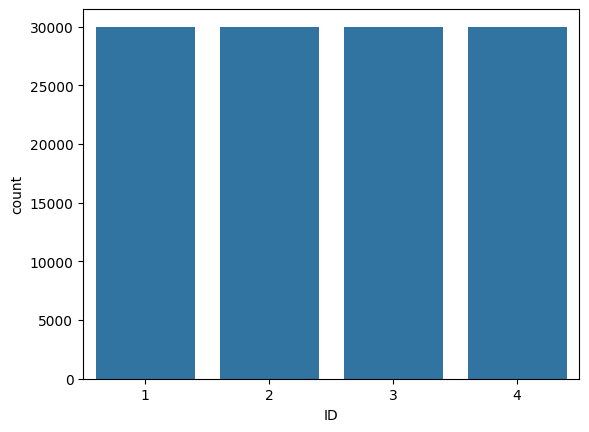

In [13]:
sns.countplot(x = 'ID', data = train_data)
plt.show()

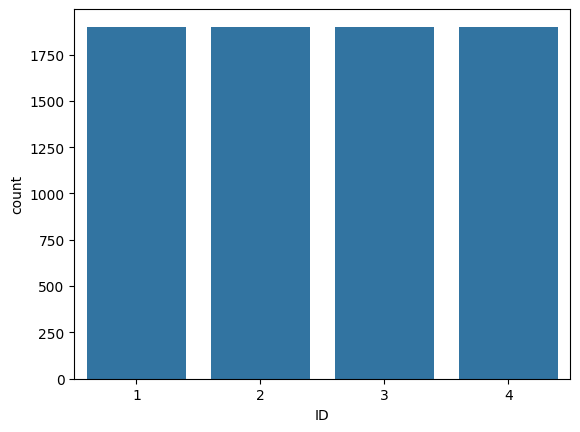

In [14]:
sns.countplot(x = 'ID', data = test_data)
plt.show()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


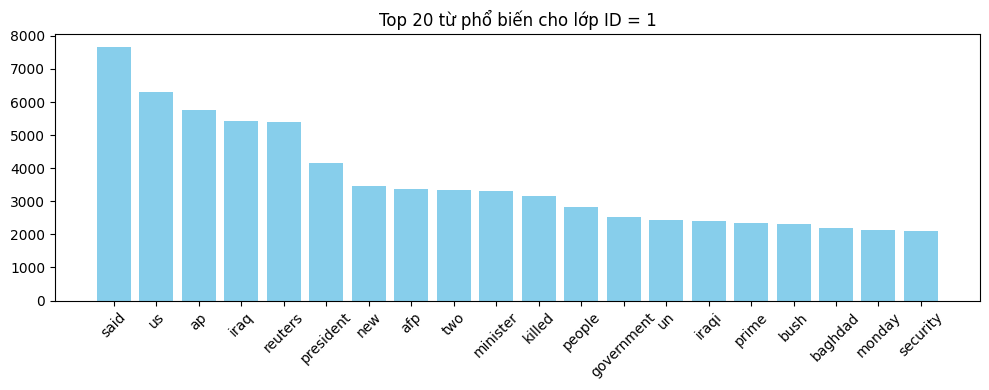

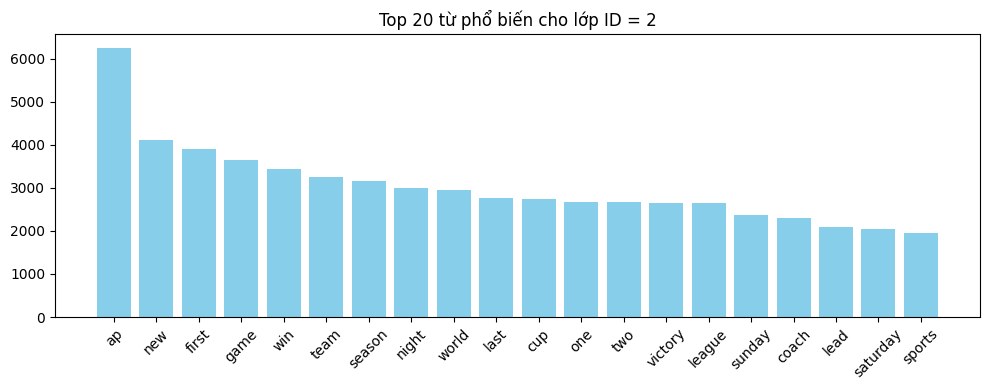

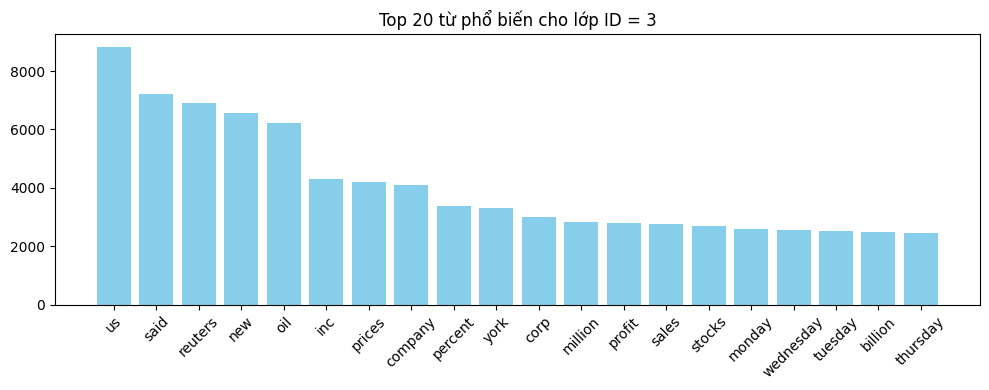

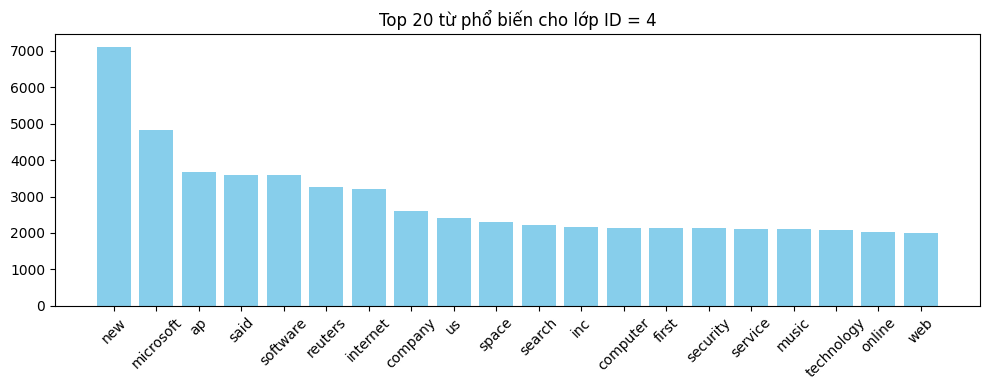

In [15]:
from collections import Counter

nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return filtered_tokens

for label in sorted(train_data['ID'].unique()):
    subset = train_data[train_data['ID'] == label]
    all_tokens = []
    for doc in subset['text']:
        all_tokens.extend(preprocess(doc))
    word_freq = Counter(all_tokens)
    most_common = word_freq.most_common(20)

    words, freqs = zip(*most_common)
    plt.figure(figsize=(10, 4))
    plt.bar(words, freqs, color='skyblue')
    plt.title(f'Top 20 từ phổ biến cho lớp ID = {label}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# <p style="font-family:Arial;font-size:150%;text-align:center;color:#FF0000;"> Data Processing</p>

In [16]:

train_x = train_data.text[:60000]
test_x = test_data.text
train_y = train_data.ID[:60000]
test_y = test_data.ID

# <p style="font-family:Arial;font-size:100%;text-align:center;color:#FF0000;"> Xóa các kí hiệu trong HTML</p>

In [17]:
def xoa_html(text):
    html=re.compile('<.*?')
    cleaned_text=html.sub('',text)
    return cleaned_text
train_x = train_x.apply(xoa_html)
test_x = test_x.apply(xoa_html)

# <p style="font-family:Arial;font-size:100%;text-align:center;color:#FF0000;"> Xóa các kí hiệu URL</p>

In [18]:
def xoa_url(text):
    """
    Câu regex này sẽ tìm các URL trong chuỗi theo hai định dạng:
    Bắt đầu bằng http:// hoặc https://
    Bắt đầu bằng www.
    """
    url=re.compile(r'https?://\S+|www\.\S+')
    return url.sub('',text)
train_x = train_x.apply(xoa_url)
test_x = test_x.apply(xoa_url)

In [19]:
print(train_x[0])

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


# <p style="font-family:Arial;font-size:100%;text-align:center;color:#FF0000;"> Tokenization</p>

In [20]:
def tokenize(text):
    """
    Một hoặc nhiều ký tự là: chữ cái, chữ số, dấu gạch dưới (_), hoặc dấu nháy đơn '
    """
    token = re.findall("[\w']+", text)
    return token
train_x = train_x.apply(tokenize)
test_x = test_x.apply(tokenize)

# <p style="font-family:Arial;font-size:100%;text-align:center;color:#FF0000;"> Chữ thường</p>

In [21]:
train_x = train_x.apply(lambda x: [word.lower() for word in x])
test_x = test_x.apply(lambda x: [word.lower() for word in x])

# <p style="font-family:Arial;font-size:100%;text-align:center;color:#FF0000;"> Xóa các StopWords</p>

In [22]:
def xoa_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return [word for word in text if word not in stop_words]
train_x = train_x.apply(xoa_stopwords)
test_x = test_x.apply(xoa_stopwords)

# <p style="font-family:Arial;font-size:100%;text-align:center;color:#FF0000;"> Xóa các dấu câu</p>

In [23]:
def xoa_dau(text):
    return [''.join(char for char in word if char not in string.punctuation) for word in text]
train_x = train_x.apply(xoa_dau)
test_x = test_x.apply(xoa_dau)


# <p style="font-family:Arial;font-size:100%;text-align:center;color:#FF0000;"> Xóa dữ liệu số</p>

In [24]:
def xoa_so(text):
    return [''.join(char for char in word if char not in string.digits) for word in text if word]
train_x = train_x.apply(xoa_so)
test_x = test_x.apply(xoa_so)

# <p style="font-family:Arial;font-size:100%;text-align:center;color:#FF0000;"> Stemming</p>

In [25]:
from nltk.stem import PorterStemmer
def stemming(text):
    porter_stemmer = PorterStemmer()
    return [porter_stemmer.stem(word) for word in text]
train_x = train_x.apply(stemming)
test_x = test_x.apply(stemming)

# <p style="font-family:Arial;font-size:100%;text-align:center;color:#FF0000;"> Xóa từ thừa</p>

In [26]:
def xoa_thua(word_list):
    extra = ['href', 'lt', 'gt', 'ii', 'iii', 'ie', 'quot', 'com']
    cleaned_list = []
    for word in word_list:
        if word not in extra:
            cleaned_list.append(word)
    return cleaned_list
train_x = train_x.apply(xoa_thua)
test_x = test_x.apply(xoa_thua)

# <p style="font-family:Arial;font-size:100%;text-align:center;color:#FF0000;"> Thêm khoảng trắng vào các từ</p>


In [27]:
def them(sentence):
    joined_sentence = ' '.join(sentence)
    return joined_sentence

train_x = train_x.apply(them)
test_x = test_x.apply(them)


In [28]:
print(train_x)

0        wall st bear claw back black reuter reuter sho...
1        carlyl look toward commerci aerospac reuter re...
2        oil economi cloud stock outlook reuter reuter ...
3        iraq halt oil export main southern pipelin reu...
4        oil price soar time record pose new menac us e...
                               ...                        
59995    make   billion month cri poverti financ minist...
59996    russian rocket take new russian us crew iss ru...
59997    hacker use beckham bait softwar hacker use sna...
59998    credit card go mobil mobil phone giant motorol...
59999    studi find technolog could support mountain mo...
Name: text, Length: 60000, dtype: object


# <p style="font-family:Arial;font-size:150%;text-align:center;color:#FF0000;"> Trích xuất đặc trưng</p>

In [29]:
tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 3))
train_1 = tfidf.fit_transform(train_x)
test_1 = tfidf.transform(test_x)
print(len(tfidf.vocabulary_))
print("100 đặc trưng đầu tiên")
print(list(tfidf.vocabulary_.keys())[:100])
train_arr = train_1.toarray()
test_arr = test_1.toarray()

26204
100 đặc trưng đầu tiên
['wall', 'st', 'bear', 'claw', 'back', 'black', 'reuter', 'short', 'seller', 'street', 'dwindl', 'band', 'ultra', 'cynic', 'see', 'green', 'wall st', 'claw back', 'reuter reuter', 'wall street', 'look', 'toward', 'commerci', 'aerospac', 'privat', 'invest', 'firm', 'group', 'reput', 'make', 'well', 'time', 'occasion', 'controversi', 'play', 'defens', 'industri', 'quietli', 'place', 'bet', 'anoth', 'part', 'market', 'privat invest', 'invest firm', 'oil', 'economi', 'cloud', 'stock', 'outlook', 'soar', 'crude', 'price', 'plu', 'worri', 'earn', 'expect', 'hang', 'next', 'week', 'depth', 'summer', 'crude price', 'worri economi', 'earn expect', 'stock market', 'market next', 'next week', 'iraq', 'halt', 'export', 'main', 'southern', 'pipelin', 'author', 'flow', 'intellig', 'show', 'rebel', 'militia', 'could', 'strike', 'infrastructur', 'offici', 'said', 'saturday', 'oil export', 'pipelin southern', 'southern iraq', 'rebel militia', 'oil offici', 'offici said', 's

In [30]:
feature_names = tfidf.get_feature_names_out()
pd.DataFrame(train_arr[:100], columns=feature_names)

,aa,aapl,aaron,aaron peirsol,ab,ababa,abandon,abba,abbey,abbey bid,...,ziff davi ziff,zimbabw,zimbabwean,zombi,zone,zoo,zoom,zurich,zurich reuter,zvonareva
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# <p style="font-family:Arial;font-size:150%;text-align:center;color:#FF0000;"> Đánh giá mô hình</p>

In [31]:
def danhgia(y,y_pred):
    print("Đánh giá bằng F1 score")
    print(f1_score(y,y_pred,average='micro'))
    print("Độ chính xác của mô hình")
    print(accuracy_score(y,y_pred))

In [32]:
def confusion_mat(color):
    cof=confusion_matrix(test_y, pred)
    cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
    sns.set(font_scale=1.5)
    plt.figure(figsize=(8,8));

    sns.heatmap(cof, cmap=color,linewidths=1, annot=True,square=True, fmt='d', cbar=False,xticklabels=['World','Sports','Business','Science'],yticklabels=['World','Sports','Business','Science']);
    plt.xlabel("Dự đoán");
    plt.ylabel("Thực tế");

# <p style="font-family:Arial;font-size:150%;text-align:center;color:#FF0000;"> Ứng dụng mô hình </p>

# <p style="font-family:Arial;font-size:100%;text-align:center;color:#FF0000;"> Mô hình 1: Multinomial Naive Bayes</p>

In [33]:
NB_MN=MultinomialNB()
NB_MN.fit(train_arr,train_y)
pred=NB_MN.predict(test_arr)

print("20 nhãn thực đầu tiên")
print(test_y.tolist()[:20])
print("20 nhãn dự đoán đầu tiên")
print(pred.tolist()[:20])

20 nhãn thực đầu tiên
[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
20 nhãn dự đoán đầu tiên
[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3]


In [34]:
danhgia(test_y,pred)

a=round(accuracy_score(test_y,pred)*100,3)

Đánh giá bằng F1 score
0.8942105263157895
Độ chính xác của mô hình
0.8942105263157895


In [35]:
probs = NB_MN.predict_proba(test_arr)
n_classes = probs.shape[1]

auc_score = roc_auc_score(test_y, probs, multi_class='ovr')
print("AUC-ROC score (multiclass):", auc_score)

AUC-ROC score (multiclass): 0.9758151431209603


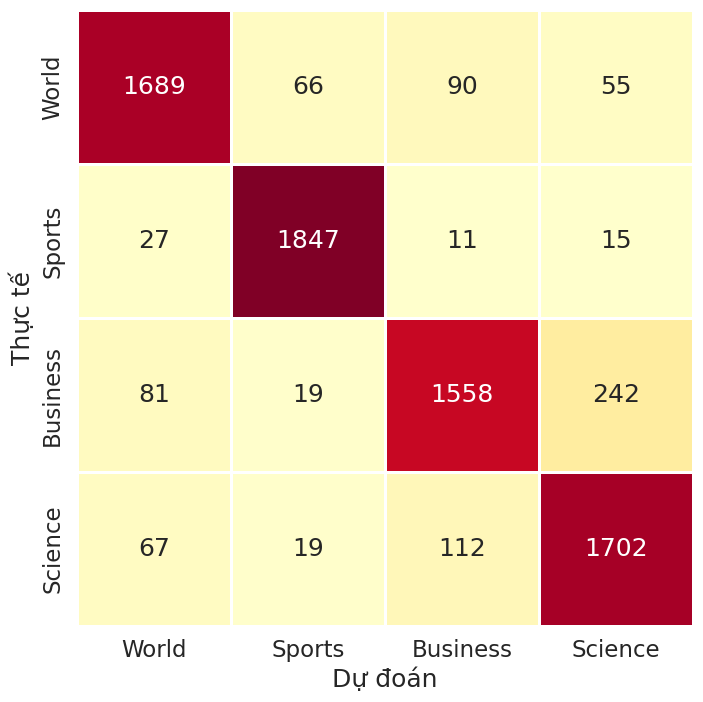

In [36]:
confusion_mat('YlOrRd')

# <p style="font-family:Arial;font-size:100%;text-align:center;color:#FF0000;">Mô hình 2: Logistic Regression</p>

In [37]:
model = LogisticRegression(max_iter=1000)
model.fit(train_arr, train_y)
pred = model.predict(test_arr)

print("20 nhãn thực đầu tiên")
print(test_y.tolist()[:20])
print("20 nhãn dự đoán đầu tiên")
print(pred.tolist()[:20])


20 nhãn thực đầu tiên
[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
20 nhãn dự đoán đầu tiên
[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [38]:
danhgia(pred,test_y)
b=round(accuracy_score(test_y,pred)*100,3)

Đánh giá bằng F1 score
0.9055263157894737
Độ chính xác của mô hình
0.9055263157894737


In [39]:


probs = model.predict_proba(test_arr)
n_classes = probs.shape[1]

auc_score = roc_auc_score(test_y, probs, multi_class='ovr')
print("AUC-ROC score (multiclass):", auc_score)


AUC-ROC score (multiclass): 0.9804833333333333


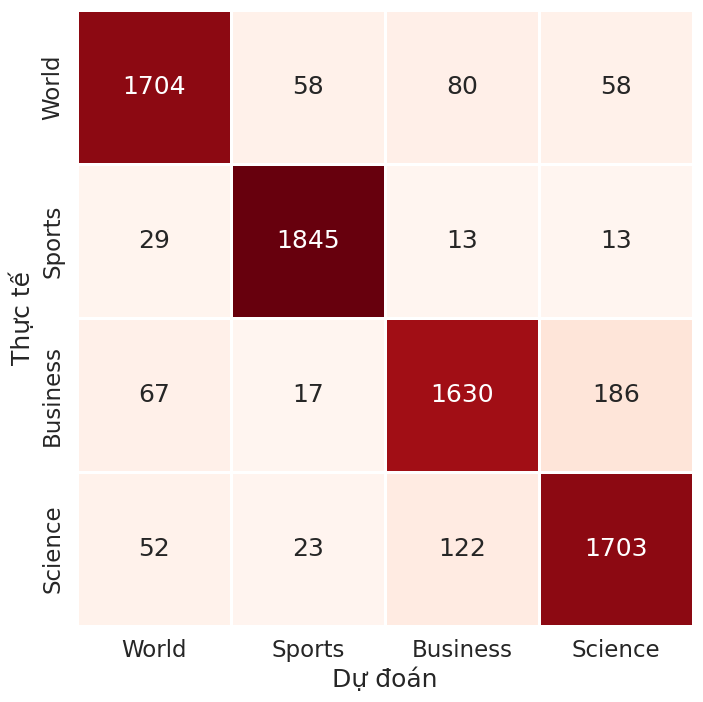

In [40]:
confusion_mat('Reds')

# <p style="font-family:Arial;font-size:150%;text-align:center;color:#FF0000;">So sánh độ chính xác giữa 2 mô hình</p>

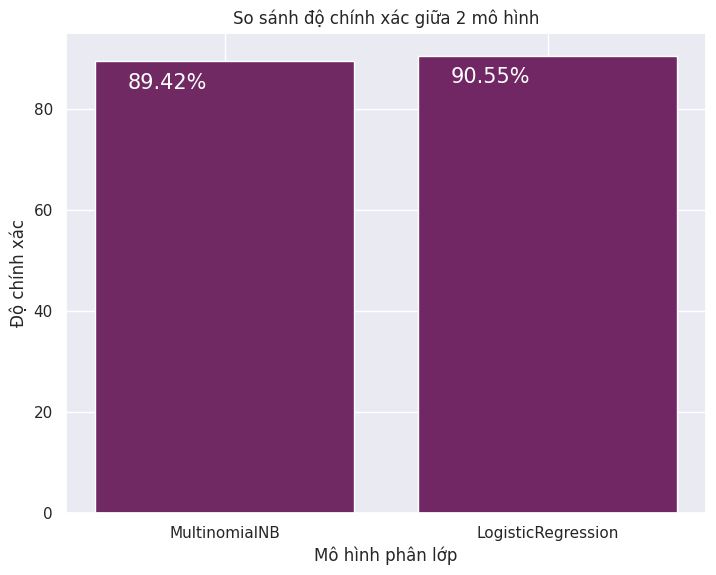

In [41]:
sns.set()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['MultinomialNB', 'LogisticRegression']
Accuracy=[a,b]
ax.bar(Models,Accuracy,color=['#702963','#702763']);
for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()-5.5, str(round(i.get_height(),2))+'%', fontsize=15, color='white')
plt.title('So sánh độ chính xác giữa 2 mô hình');
plt.ylabel('Độ chính xác');
plt.xlabel('Mô hình phân lớp');

plt.show();